# Mini VGG

In [1]:
import matplotlib as mpl
mpl.use('Agg')
%matplotlib inline
import sys, time
import numpy as np
from matplotlib import pyplot as plt


from tensorflow.keras.datasets     import cifar10
from tensorflow.keras.utils        import to_categorical
from tensorflow.keras.models       import Sequential
from tensorflow.keras.layers       import Convolution2D
from tensorflow.keras.layers       import MaxPooling2D
from tensorflow.keras.layers       import Dense
from tensorflow.keras.layers       import Flatten
from tensorflow.keras.layers       import Dropout, BatchNormalization
from tensorflow.keras.callbacks    import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adam
import tensorflow.keras.backend as K

## Funciones auxiliares

In [2]:
def graf_entrenamiento(historia, archivo):
    fig = plt.figure(figsize=(10,10))
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy')
    plt.plot(historia.history['loss'], color='blue', label='train')
    plt.plot(historia.history['val_loss'], color='orange', label='test')
    # plot accuracy
    plt.subplot(212)
    plt.title('Accuracy')
    plt.plot(historia.history['accuracy'], color='blue', label='train')
    plt.plot(historia.history['val_accuracy'], color='orange', label='test')
    # save plot to file
    plt.savefig(archivo + '_plot.png')
    plt.show()
    del(fig)
    
def load_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = cifar10.load_data()
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY
data_set = load_dataset()

## Preprocesamiento de datos


In [3]:
x_tr, y_tr, x_ts, y_ts  = data_set
x_tr = x_tr.astype('float32') / 255
x_ts = x_ts.astype('float32') / 255

In [4]:
x_tr.shape

(50000, 32, 32, 3)

In [5]:
y_tr.shape

(50000, 10)

## Definición de modelo

In [7]:
def mini_vgg(inshp=(32,32,3)):
    '''
    Vgg de 3 bloques
    '''
    act = 'relu'
    sizes = [32, 64, 128]
    sz = sizes[0]
    model = Sequential()
    model.add(Convolution2D(sz, kernel_size=(3,3), 
                            padding="same", 
                            kernel_initializer="he_uniform", 
                            activation=act, 
                            input_shape=inshp))
    model.add(Convolution2D(sz, kernel_size=(3,3), 
                            padding="same", 
                            kernel_initializer="he_uniform",
                            activation=act))
    model.add(MaxPooling2D((2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    sz= sizes[1]
    for _ in range(1):
        model.add(Convolution2D(sz, kernel_size=(3,3), 
                                padding="same", 
                                kernel_initializer="he_uniform", 
                                activation=act))
    model.add(MaxPooling2D((2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    sz= sizes[2]
    for _ in range(1):
        model.add(Convolution2D(sz, kernel_size=(3,3), 
                                padding="same", 
                                kernel_initializer="he_uniform", 
                                activation=act))
    model.add(MaxPooling2D((2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    act='tanh'
    model.add(Flatten())
    model.add(Dense(256, activation=act))
    model.add(Dropout(0.5))


    model.add(Dense(10, activation='softmax'))
    
    # compilamos el modelo
    opt = Adam(lr=0.0001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

vgg7 = mini_vgg()
vgg7.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 64)         

## Entrenamiento

In [8]:
lts=128
wrk=4
eps=10
ti = time.time()
ea = EarlyStopping(patience=3, monitor='val_loss', mode='min', verbose='1')
H = vgg7.fit(x=x_tr, y=y_tr, 
            batch_size=lts, 
            epochs=eps,
            validation_data=(x_ts, y_ts),
            shuffle=True,
            verbose=1,
            use_multiprocessing=True,
            workers=wrk)
tf = time.time()
print("Tiempo ocupado {}s".format(tf-ti))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
 1024/50000 [..............................] - ETA: 7:43 - loss: 3.0154 - accuracy: 0.1138

KeyboardInterrupt: 

In [10]:
print("Tiempo de entrenamiento {0:.2f} minutos".format((tf-ti)/60))

Tiempo de entrenamiento 53.03 minutos


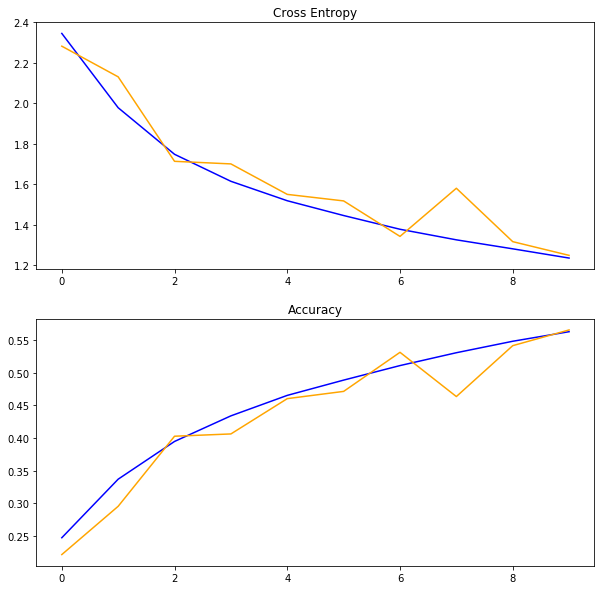

In [11]:
graf_entrenamiento(H, "vgg7_entrena")


## Evaluación



In [12]:
scores = vgg7.evaluate(x_ts,y_ts, verbose=1)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [13]:
print("Perdida {0:.2f}".format(scores[0]))
print("Precision {0:.2f}". format(scores[1]))

Perdida 1.25
Precision 0.57


## Salvamos modelo


In [15]:
vgg7.save_weights("vgg7_pesos.h5")
vgg7.save("vgg7_modelo.h5")

Entonces cómo se puede recuperar un modelo ya salvado:

In [16]:
from tensorflow.keras.models import load_model
vgg7 = load_model("vgg7_modelo.h5")

## Uso

In [17]:
import PIL
from PIL import Image
archivos = ["../Z_datasets/dog1.jpeg", 
            "../Z_datasets/dog2.jpeg",
            "../Z_datasets/cat1.jpeg",
            "../Z_datasets/cat2.jpg",
           "./bird.jpg"]

In [18]:
imgs = [None]*len(archivos)
for i,arc in enumerate(archivos):
    imgs[i] = Image.open(archivos[i])


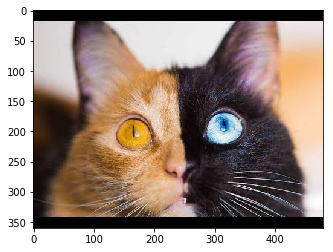

In [74]:
idx = 3
plt.imshow(imgs[idx])

In [75]:
a = imgs[idx].resize((32,32), Image.ANTIALIAS)

In [76]:
arrimg = np.array(a).reshape((1,32,32,3)).astype('float32')
type(arrimg)

numpy.ndarray

In [77]:
pred = vgg7.predict(arrimg)
print(pred)

[[0.02201715 0.04082894 0.01346723 0.11501079 0.00295436 0.17436177
  0.00456549 0.10106537 0.04640708 0.47932187]]


In [78]:
[np.round(x,2) for x in pred[0]]

[0.02, 0.04, 0.01, 0.12, 0.0, 0.17, 0.0, 0.1, 0.05, 0.48]

In [79]:
labels=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print(labels[np.argmax(pred[0])])

truck
